## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score

## Load Dataset

In [2]:
df = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv')
dft = pd.read_csv('/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv')

pd.set_option('display.max_columns', None)

## Data Overview

In [3]:
print("Training Data Shape:", df.shape)
print("Test Data Shape:", dft.shape)

Training Data Shape: (116023, 52)
Test Data Shape: (29006, 51)


## Check for different types of data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 52 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   trafficSource.isTrueDirect                    42890 non-null   object 
 1   purchaseValue                                 116023 non-null  float64
 2   browser                                       116023 non-null  object 
 3   device.screenResolution                       116023 non-null  object 
 4   trafficSource.adContent                       2963 non-null    object 
 5   trafficSource.keyword                         44162 non-null   object 
 6   screenSize                                    116023 non-null  object 
 7   geoCluster                                    116023 non-null  object 
 8   trafficSource.adwordsClickInfo.slot           4281 non-null    object 
 9   device.mobileDeviceBranding                   11

In [5]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29006 entries, 0 to 29005
Data columns (total 51 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   userChannel                                   29006 non-null  object 
 1   date                                          29006 non-null  int64  
 2   browser                                       29006 non-null  object 
 3   device.browserSize                            29006 non-null  object 
 4   device.browserVersion                         29006 non-null  object 
 5   deviceType                                    29006 non-null  object 
 6   device.flashVersion                           29006 non-null  object 
 7   device.isMobile                               29006 non-null  bool   
 8   device.language                               29006 non-null  object 
 9   device.mobileDeviceBranding                   29006 non-null 

## Check for missing Values

Description:
Calculate and print percentage of missing values per column in train and test datasets.

Intuition:
Identifying missing data guides preprocessing strategies like imputation or column removal.

In [6]:
print("Missing values in training data (%):")
print(df.isnull().sum() / len(df) * 100)
print("Missing values in test data (%):")
print(dft.isnull().sum() / len(dft) * 100)

Missing values in training data (%):
trafficSource.isTrueDirect                      63.033192
purchaseValue                                    0.000000
browser                                          0.000000
device.screenResolution                          0.000000
trafficSource.adContent                         97.446196
trafficSource.keyword                           61.936857
screenSize                                       0.000000
geoCluster                                       0.000000
trafficSource.adwordsClickInfo.slot             96.310214
device.mobileDeviceBranding                      0.000000
device.mobileInputSelector                       0.000000
userId                                           0.000000
trafficSource.campaign                           0.000000
device.mobileDeviceMarketingName                 0.000000
geoNetwork.networkDomain                         0.000000
gclIdPresent                                     0.000000
device.operatingSystemVersion      

# Data Preprocessing

## Identify the duplicates

Description:
Detect duplicate rows in training data and remove them to avoid bias and overfitting.

Intuition:
Duplicates can skew model learning, causing overestimation of performance or misleading feature importance.

In [7]:
duplicates = df.duplicated()

# Display the number of duplicate rows
print(f"Data shape after removing duplicates: {df.shape}")
print(f"Number of duplicate rows: {duplicates.sum()}")

# Display the duplicate rows
duplicate_rows = df[duplicates]
df = df[~duplicates]
print(f"Data shape after removing duplicates: {df.shape}")

Data shape after removing duplicates: (116023, 52)
Number of duplicate rows: 236
Data shape after removing duplicates: (115787, 52)


## Drop columns with more than 50% missing values

Remove columns with over half their values missing since these provide limited useful information.

In [8]:
threshold = 0.5
col_to_drop = df.columns[df.apply(lambda x: x.isnull().sum() / len(x), axis=0) > threshold].tolist()
df.drop(columns=col_to_drop, inplace=True)
dft.drop(columns=col_to_drop, inplace=True)

## Fill missing Values

Description:
Fill specific missing values using domain-appropriate defaults or statistics (e.g., zero or median).

Intuition:
Models can’t handle missing data directly; filling ensures smooth training and inference.

In [9]:
# Fill missing values in train data
df['new_visits'].fillna(0, inplace=True)
df.dropna(inplace=True)

# Fill missing values in test data
dft['new_visits'].fillna(0, inplace=True)
dft['pageViews'].fillna(dft['pageViews'].median(), inplace=True)

/tmp/ipykernel_35/4106614782.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['new_visits'].fillna(0, inplace=True)
/tmp/ipykernel_35/4106614782.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

In [10]:
# Get column metadata
data_types = df.dtypes
unique_counts = df.nunique()
na_counts = df.isna().sum()
total_entries = len(df)

# Create summary dataframe
summary = pd.DataFrame({
    'Data_Type': data_types,
    'Unique_Counts': unique_counts,
    'NA_Counts': na_counts,
    'Total_Entries': total_entries,
})

# Sort and format display
summary_sorted = summary.sort_values(by='Unique_Counts', ascending=False)\
                       .style.format({'NA_Percentage': '{:.2%}'})

display(summary_sorted)

,Data_Type,Unique_Counts,NA_Counts,Total_Entries
sessionStart,int64,107380,0,115779
sessionId,int64,107371,0,115779
userId,int64,100493,0,115779
purchaseValue,float64,6766,0,115779
geoNetwork.city,object,695,0,115779
date,int64,638,0,115779
geoNetwork.region,object,388,0,115779
sessionNumber,int64,230,0,115779
totalHits,int64,225,0,115779
locationCountry,object,193,0,115779


# Exploratory Data Analysis (EDA)

## Display value counts for each column

Convert date strings to datetime objects and extract useful components like month and day of week.

In [11]:
for col in df.columns:
    print(f"Value counts for {col}:")
    print(df[col].value_counts())
    print('\n')

Value counts for purchaseValue:
purchaseValue
0.0            91982
16990000.0       440
18990000.0       325
33590000.0       301
19990000.0       288
               ...  
27130000.0         1
36110000.0         1
77960000.0         1
33170000.0         1
169750000.0        1
Name: count, Length: 6766, dtype: int64


Value counts for browser:
browser
Chrome                                                  84305
Safari                                                  19159
Firefox                                                  4026
Internet Explorer                                        2152
Android Webview                                          1471
Edge                                                     1214
Safari (in-app)                                           791
Opera Mini                                                732
Samsung Internet                                          563
Opera                                                     546
UC Browser                 

## Feature Engineering

#### Convert date column to datetime

In [12]:
# Process Train Data
df['dates'] = pd.to_datetime(df['date'], format='%Y%m%d')
df['month'] = df['dates'].dt.month
df['dayofweek'] = df['dates'].dt.dayofweek

# Process Test Data
dft['dates'] = pd.to_datetime(dft['date'], format='%Y%m%d')
dft['month'] = dft['dates'].dt.month
dft['dayofweek'] = dft['dates'].dt.dayofweek

- **`engagementScore`**: Measures user interaction by combining page views and total hits, normalized by session number, indicating browsing intensity per session.
- **`sessionCount`** & **`sessionFrequency`**: Count the total number of sessions per user, reflecting how often the user visits the site.  
- **`geoDiversityScore`**: Counts the unique cities from which a user has accessed the site, showing geographic diversity in browsing.  
- **`isNewYear`**: Flags data points from January, capturing seasonal effects on user behavior and purchases.  
- **`averagePurchaseValue`**: Calculates the user’s average historical purchase amount, serving as a predictor of future spending.
- **`sessionFrequency`**: Represents the total number of sessions a user has had by counting the occurrences of `sessionId` grouped by `userId`. This feature reflects how often a user visits the site, which can indicate their engagement level and potential likelihood to make a purchase.
- **`campaignCount`**: Tracks the number of unique marketing campaigns the user has been exposed to, measuring marketing impact on purchases.
- **`sessionHour`**: Extracts the hour from `sessionStart`, useful for analyzing user behavior by time of day.
- **`isWeekend`**: Flags sessions that occur on weekends, highlighting differences in user engagement.
- **`isReturningVisitor`**: Indicates if a user is a returning visitor based on `new_visits`, reflecting user loyalty.
- **`channel_device`**: Combines `userChannel` and `deviceType` into a single string for analyzing behavior across platforms.

In [13]:
# Feature Engineering for train data
df['engagementScore'] = df['pageViews'] * df['totalHits'] / df['sessionNumber']
df['sessionCount'] = df.groupby('userId')['sessionId'].transform('count')
df['geoDiversityScore'] = df.groupby('userId')['geoNetwork.city'].transform('nunique')
df['isNewYear'] = df['month'].apply(lambda x: 1 if x == 1 else 0)
df['averagePurchaseValue'] = df.groupby('userId')['purchaseValue'].transform('mean')
df['sessionFrequency'] = df.groupby('userId')['sessionId'].transform('count')
df['campaignCount'] = df.groupby('userId')['trafficSource.campaign'].transform('nunique')
df['isWeekend'] = df['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
df['isReturningVisitor'] = np.where(df['new_visits'] == 0, 1, 0)
df['channel_device'] = df['userChannel'].astype(str) + "_" + df['deviceType'].astype(str)

# Feature Engineering for test data
dft['engagementScore'] = dft['pageViews'] * dft['totalHits'] / dft['sessionNumber']
dft['sessionCount'] = dft.groupby('userId')['sessionId'].transform('count')
dft['geoDiversityScore'] = dft.groupby('userId')['geoNetwork.city'].transform('nunique')
dft['isNewYear'] = dft['month'].apply(lambda x: 1 if x == 1 else 0)
dft['sessionFrequency'] = dft.groupby('userId')['sessionId'].transform('count')
dft['campaignCount'] = dft.groupby('userId')['trafficSource.campaign'].transform('nunique')
dft['isWeekend'] = dft['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
dft['isReturningVisitor'] = np.where(dft['new_visits'] == 0, 1, 0)
dft['channel_device'] = dft['userChannel'].astype(str) + "_" + dft['deviceType'].astype(str)

In [14]:
# impute average purchase value for test data
average_purchase_value = df.groupby('userId')['purchaseValue'].mean().reset_index()
average_purchase_value.columns = ['userId', 'averagePurchaseValue']
dft = dft.merge(average_purchase_value, on='userId', how='left')
dft['averagePurchaseValue'].fillna(0, inplace=True)

/tmp/ipykernel_35/1571897289.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dft['averagePurchaseValue'].fillna(0, inplace=True)


### Will a purchase happen?

In [15]:
# For train data, create a binary target variable for purchase
df['is_purchase'] = np.where(df['purchaseValue'] > 0, 1, 0)

# For test data, we will predict purchase using classification

## Drop unnecessary Columns

Dropping the columns which contains just one unique value

In [16]:
# Drop columns with single unique value
columns_to_drop = df.columns[df.nunique() == 1]
print(columns_to_drop)
df.drop(columns=columns_to_drop, inplace=True)
dft.drop(columns=columns_to_drop, inplace=True)

Index(['device.screenResolution', 'screenSize', 'device.mobileDeviceBranding',
       'device.mobileInputSelector', 'device.mobileDeviceMarketingName',
       'device.operatingSystemVersion', 'device.flashVersion', 'totals.visits',
       'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize',
       'socialEngagementType', 'locationZone', 'device.mobileDeviceModel',
       'device.language', 'device.browserVersion', 'device.screenColors'],
      dtype='object')


In [17]:
columns_to_drop = ['geoNetwork.metro', 'geoNetwork.city', 'locationCountry', 'geoNetwork.subContinent', 'os', 'sessionId', 'trafficSource', 'geoNetwork.region', 'geoNetwork.networkDomain', 'trafficSource.campaign', 'dates', 'userId', 'browser', 'trafficSource.medium']

df.drop(columns_to_drop, axis=1, inplace=True)
dft.drop(columns_to_drop, axis=1, inplace=True)

In [18]:
df.shape, dft.shape

((115779, 26), (29006, 24))

## Vistuaization Time

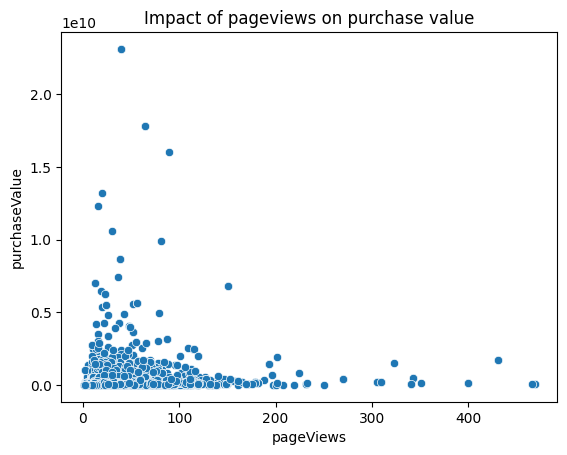

In [19]:
sns.scatterplot(data=df,x='pageViews',y='purchaseValue')
plt.title("Impact of pageviews on purchase value")
plt.xlabel("pageViews")
plt.ylabel("purchaseValue")
plt.show()

The scatter plot illustrates the relationship between pageviews and purchase value

As pageviews increase, the purchase value tends to decrease, with most data points clustered at lower pageview counts. This suggests that while users may browse extensively, it does not necessarily lead to higher purchases. 

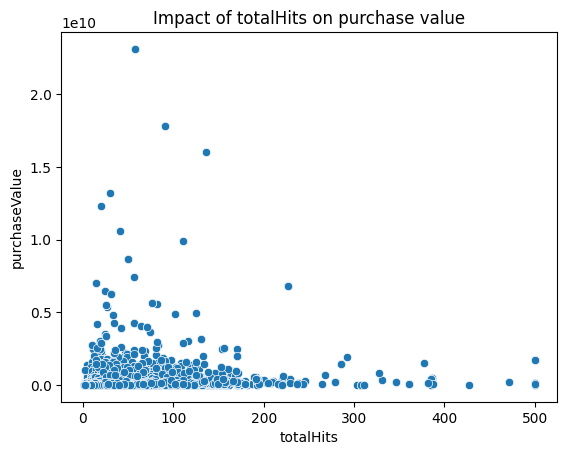

In [20]:
sns.scatterplot(data=df,x='totalHits',y='purchaseValue')
plt.title("Impact of totalHits on purchase value")
plt.xlabel("totalHits")
plt.ylabel("purchaseValue")
plt.show()

The pattern between the pageViews and totalHits is same. As the intensity increases, the probablity of higher purchase decreases.

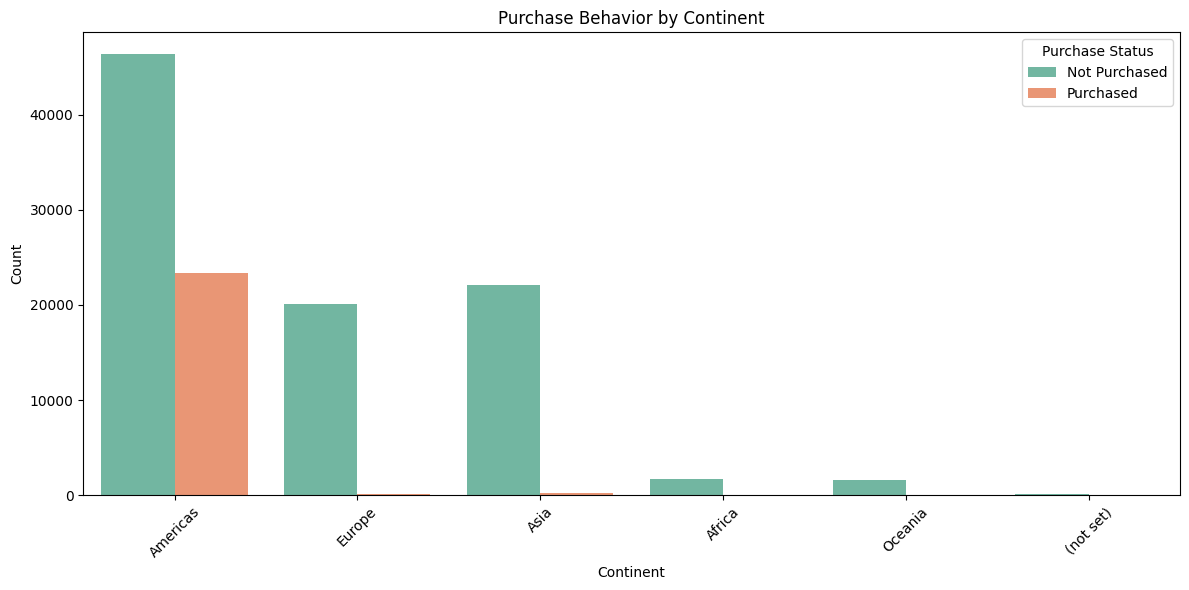

In [21]:

df['is_purchase'] = df['is_purchase'].astype('category')

# Create a count plot for purchases by continent
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='geoNetwork.continent', hue='is_purchase', palette='Set2')

# Adding titles and labels
plt.title('Purchase Behavior by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Purchase Status', labels=['Not Purchased', 'Purchased'])
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

Americas is haveing the maximum purchasers compared to others.

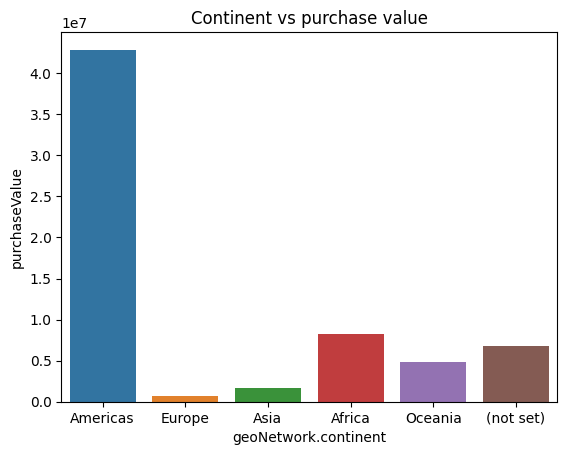

In [22]:
sns.barplot(data=df,x='geoNetwork.continent',y='purchaseValue',errorbar=None)
plt.title('Continent vs purchase value')
plt.show()

Also, Americas is contributing the highest in terms of purchaseValue, followed with Africa

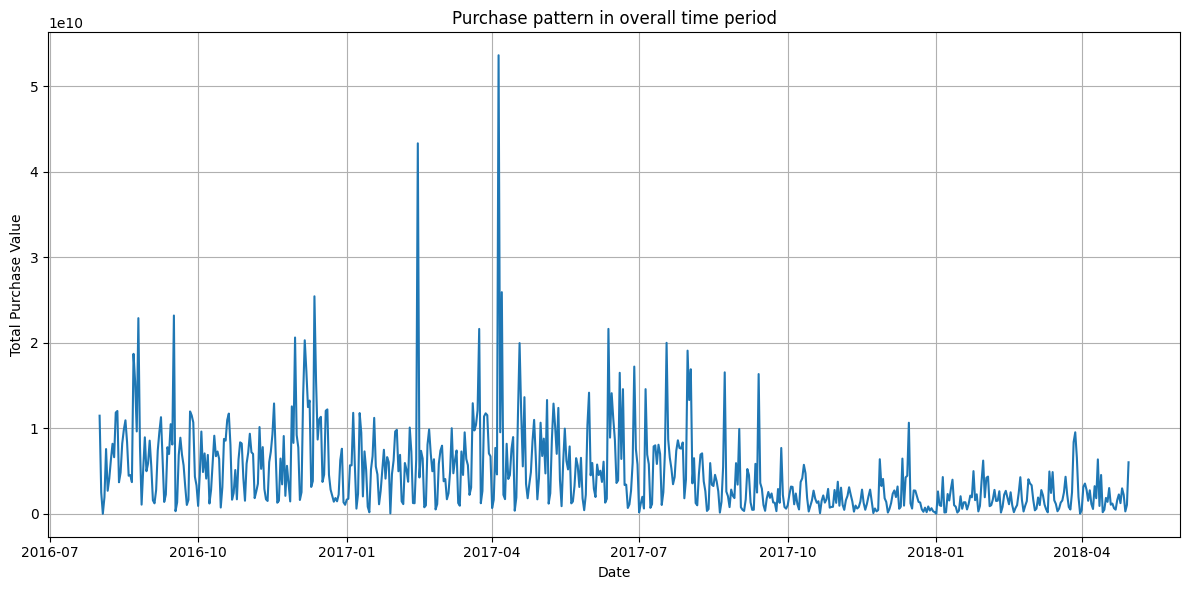

In [23]:
df1 = df.copy()
df1['date'] = pd.to_datetime(df1['date'], format='%Y%m%d')
daily_sales = df1.groupby(df1['date'].dt.date)['purchaseValue'].sum()


daily_sales.plot(kind='line', figsize=(12,6), title='Daily Total Purchase Value')
plt.xlabel('Date')
plt.ylabel('Total Purchase Value')
plt.title('Purchase pattern in overall time period')
plt.grid(True)
plt.tight_layout()
plt.show()

There were noticeable spikes in purchases, especially between late 2016 and early 2017, which were marked by days of unusually high transactions.

After mid-2017, both the number and value of purchases began to decline.

Overall, daily purchase values fluctuate significantly, showing no clear trend.

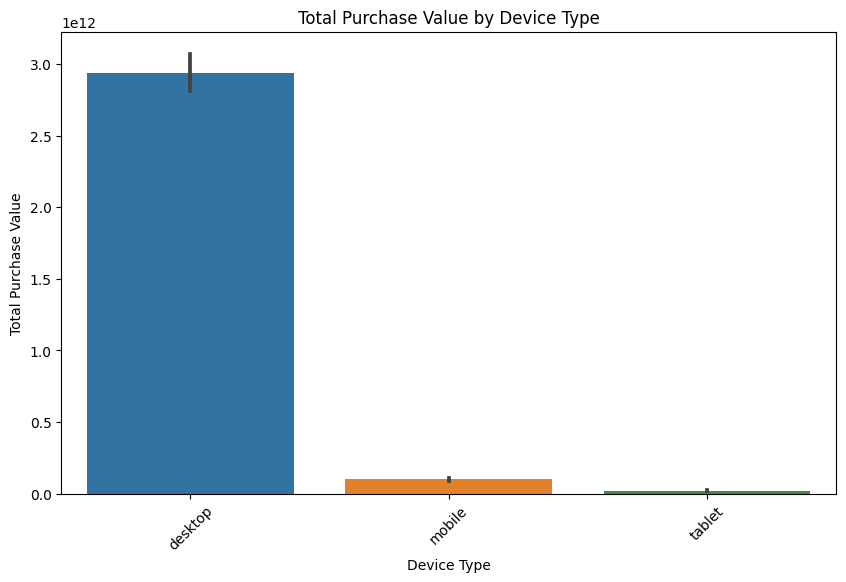

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x='deviceType', y='purchaseValue', data=df, estimator=sum)
plt.title('Total Purchase Value by Device Type')
plt.xlabel('Device Type')
plt.ylabel('Total Purchase Value')
plt.xticks(rotation=45)
plt.show()

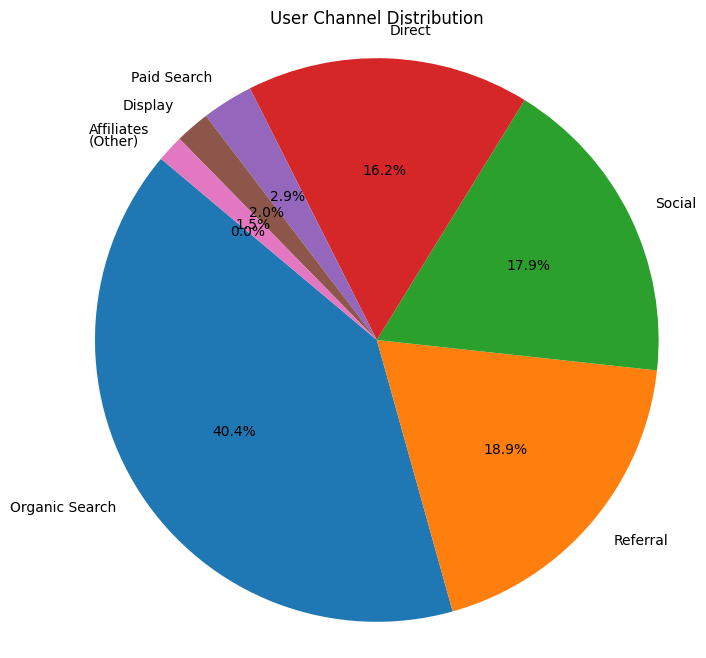

In [25]:
plt.figure(figsize=(8, 8))
user_channel_counts = df['userChannel'].value_counts()
plt.pie(user_channel_counts, labels=user_channel_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('User Channel Distribution')
plt.axis('equal')
plt.show()

In [26]:
df.columns

Index(['purchaseValue', 'geoCluster', 'gclIdPresent', 'sessionNumber',
       'pageViews', 'date', 'deviceType', 'userChannel', 'totalHits',
       'sessionStart', 'geoNetwork.continent', 'device.isMobile', 'new_visits',
       'month', 'dayofweek', 'engagementScore', 'sessionCount',
       'geoDiversityScore', 'isNewYear', 'averagePurchaseValue',
       'sessionFrequency', 'campaignCount', 'isWeekend', 'isReturningVisitor',
       'channel_device', 'is_purchase'],
      dtype='object')

## Encode Columns

In [27]:
# Get column metadata
data_types = df.dtypes
unique_counts = df.nunique()
na_counts = df.isna().sum()
total_entries = len(df)

# Create summary dataframe
summary = pd.DataFrame({
    'Data_Type': data_types,
    'Unique_Counts': unique_counts,
    'NA_Counts': na_counts,
    'Total_Entries': total_entries,
})

summary = summary[summary['Data_Type'] == 'object']

# Sort and format display
summary_sorted = summary.sort_values(by='Unique_Counts', ascending=False)\
                       .style.format({'NA_Percentage': '{:.2%}'})

display(summary_sorted)

,Data_Type,Unique_Counts,NA_Counts,Total_Entries
channel_device,object,24,0,115779
userChannel,object,8,0,115779
geoNetwork.continent,object,6,0,115779
geoCluster,object,5,0,115779
deviceType,object,3,0,115779


In [28]:
col_enc = df.select_dtypes(include='object').columns
le = LabelEncoder()
# Encode categorical variables in train data
for col in col_enc:
    df[col] = le.fit_transform(df[col])

# Encode categorical variables in test data
for col in col_enc:
    dft[col] = le.fit_transform(dft[col])

# Model training

## Prepare training data

### Classification code to identify if there was a purchase made by the user or not

In [29]:
df.shape, dft.shape

((115779, 26), (29006, 24))

In [30]:
# Prepare training data
X_train_c = df.drop(['purchaseValue', 'is_purchase', 'sessionStart', 'sessionNumber'], axis=1)
y_train_c = df['is_purchase']

In [31]:
X_train_c

,geoCluster,gclIdPresent,pageViews,date,deviceType,userChannel,totalHits,geoNetwork.continent,device.isMobile,new_visits,month,dayofweek,engagementScore,sessionCount,geoDiversityScore,isNewYear,averagePurchaseValue,sessionFrequency,campaignCount,isWeekend,isReturningVisitor,channel_device
0,1,0,1.0,20170714,0,7,1,2,False,1.0,7,4,1.0,1,1,0,0.0,1,1,0,0,21
1,2,0,1.0,20170519,0,2,1,2,False,1.0,5,4,1.0,1,1,0,0.0,1,1,0,0,6
2,1,0,6.0,20171020,0,4,6,4,False,0.0,10,4,18.0,1,1,0,0.0,1,1,0,1,12
3,3,0,1.0,20170103,0,7,1,3,False,1.0,1,1,1.0,1,1,1,0.0,1,1,0,0,21
4,2,0,54.0,20161006,0,2,66,2,False,1.0,10,3,3564.0,2,1,0,88950000.0,2,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116018,2,0,26.0,20170717,0,6,28,2,False,1.0,7,0,728.0,2,1,0,35180000.0,2,1,0,0,18
116019,4,0,1.0,20161108,0,2,1,2,False,1.0,11,1,1.0,1,1,0,0.0,1,1,0,0,6
116020,0,0,1.0,20160805,0,6,1,3,False,0.0,8,4,0.5,2,1,0,0.0,2,1,0,1,18
116021,4,0,2.0,20171002,0,4,2,2,False,1.0,10,0,4.0,1,1,0,0.0,1,1,0,0,12


In [32]:
print(X_train_c.dtypes)

geoCluster                int64
gclIdPresent              int64
pageViews               float64
date                      int64
deviceType                int64
userChannel               int64
totalHits                 int64
geoNetwork.continent      int64
device.isMobile            bool
new_visits              float64
month                     int32
dayofweek                 int32
engagementScore         float64
sessionCount              int64
geoDiversityScore         int64
isNewYear                 int64
averagePurchaseValue    float64
sessionFrequency          int64
campaignCount             int64
isWeekend                 int64
isReturningVisitor        int64
channel_device            int64
dtype: object


In [33]:
# Train Random Forest Classifier
rfc = RandomForestClassifier()
rfc.fit(X_train_c, y_train_c)

RandomForestClassifier()

In [34]:
X_test_c = pd.DataFrame()
col_train = X_train_c.columns
for col in col_train:
    X_test_c[col] = dft[col]

In [35]:
X_train_c.columns, X_test_c.columns

(Index(['geoCluster', 'gclIdPresent', 'pageViews', 'date', 'deviceType',
        'userChannel', 'totalHits', 'geoNetwork.continent', 'device.isMobile',
        'new_visits', 'month', 'dayofweek', 'engagementScore', 'sessionCount',
        'geoDiversityScore', 'isNewYear', 'averagePurchaseValue',
        'sessionFrequency', 'campaignCount', 'isWeekend', 'isReturningVisitor',
        'channel_device'],
       dtype='object'),
 Index(['geoCluster', 'gclIdPresent', 'pageViews', 'date', 'deviceType',
        'userChannel', 'totalHits', 'geoNetwork.continent', 'device.isMobile',
        'new_visits', 'month', 'dayofweek', 'engagementScore', 'sessionCount',
        'geoDiversityScore', 'isNewYear', 'averagePurchaseValue',
        'sessionFrequency', 'campaignCount', 'isWeekend', 'isReturningVisitor',
        'channel_device'],
       dtype='object'))

In [36]:
# Predict on test data
X_test_c['is_purchase'] = rfc.predict(X_test_c)

In [37]:
X_train_c['is_purchase'] = df['is_purchase']
X_test_r = pd.DataFrame()

### Regression code to find the exact purchase amount

In [ ]:
# Prepare training data
X_train_r = df.drop('purchaseValue', axis=1)
y_train_r = df['purchaseValue']

# Prepare test data
X_test_c['sessionNumber'] = dft['sessionNumber']
X_test_c['sessionStart'] = dft['sessionStart']

# Align test set columns with training set
X_test_r = X_test_c[X_train_r.columns]

# Define models and hyperparameters
models = {
    'Random Forest': (RandomForestRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    'Gradient Boosting': (GradientBoostingRegressor(random_state=42), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }),
    'Linear Regression': (LinearRegression(), {})
}

best_model = None
best_r2 = -np.inf

# Hyperparameter tuning using GridSearchCV
for model_name, (model, params) in models.items():
    print(f"\nTuning {model_name}...")
    grid = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=5, n_jobs=-1)
    grid.fit(X_train_r, y_train_r)

    print(f"Best Parameters: {grid.best_params_}")
    print(f"Best Cross-Validation R2: {grid.best_score_}")

    # Evaluate on training data
    train_pred = grid.predict(X_train_r)
    train_r2 = r2_score(y_train_r, train_pred)
    print(f"{model_name} Training R2: {train_r2}")

    # Save best model if better
    if train_r2 > best_r2:
        best_r2 = train_r2
        best_model = grid.best_estimator_

# Train the best model on full training data
print(f"\nUsing best model: {type(best_model).__name__}")
best_model.fit(X_train_r, y_train_r)


Tuning Random Forest...
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation R2: 0.7099868936079183
Random Forest Training R2: 0.9662408452064826

Tuning Gradient Boosting...


In [ ]:
# Train the model
rfr = RandomForestRegressor(min_samples_split=2, n_estimators=50)
rfr.fit(X_train_r, y_train_r)

# Predict on test data
y_pred = rfr.predict(X_test_r)

# Create DataFrame with 'id' and 'purchaseValue'
submission = pd.DataFrame({
    'id': X_test_r.index,
    'purchaseValue': y_pred
})

# Save predictions to CSV
submission.to_csv('submission.csv', index=False)

In [ ]:
# # Zip and sort by importance
# importances = list(zip(df.columns, rfr.feature_importances_))
# importances_sorted = sorted(importances, key=lambda x: x[1], reverse=True)

# # Print top features
# for name, score in importances_sorted:
#     print(f"{name}: {score:.4f}")